In [149]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import networkx as nx

In [150]:
import cv2
import numpy as np

def parse_png_directory(directory):
  """Parses a PNG directory and converts PNG files into NumPy arrays.

  Args:
    directory: The path to the PNG directory.

  Returns:
    A list of NumPy arrays, where each array represents one PNG file.
  """

  png_files = []
  for file in os.listdir(directory):
    if file.endswith(".png"):
      png_files.append(file)

  numpy_arrays = []
  for jpg_file in png_files:
    numpy_array = cv2.imread(os.path.join(directory, jpg_file))
    grayscale_image = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2GRAY)
    image_vec = np.reshape(grayscale_image, (-1,))
    numpy_arrays.append(image_vec)

  return np.vstack(numpy_arrays)

In [151]:
directory = "./cleaned_images"
images = parse_png_directory(directory)
images.shape

(1130, 100000)

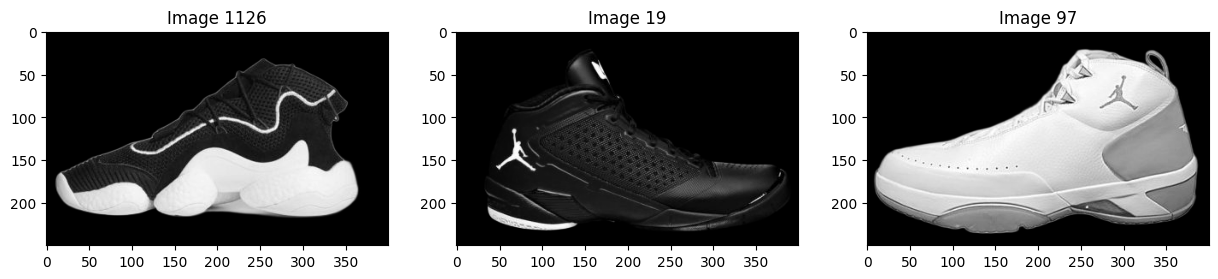

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
random_nums = []
for i, ax in enumerate(axs.flatten()):
    random_num = np.random.choice(range(images.shape[0]))
    random_nums.append(random_num)
    ax.imshow(np.reshape(images[random_num], (250,400)), cmap="gray")
    ax.set_title(f"Image {random_num}")

In [153]:
def get_distance_matrix(W):
    # Assemble weighted edges matrix
    n = np.shape(W)[0]
    G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            G.add_weighted_edges_from([(i, j, min(W[i,j], W[j,i]))])
    
    # Implement dijkstra's algorithm to get distance matrix
    distances = dict(nx.all_pairs_dijkstra_path_length(G))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = distances[i][j]
    
    return D

In [154]:
def isomap(G):
    N = len(G)
    D = get_distance_matrix(G)
    D = (D + D.T)/2    
    ones = np.ones([N,1])
    H = np.eye(N) - 1 / N * ones.dot(ones.T)
    C = -H.dot(D**2).dot(H)/(2*N)
    eigenvalues, eigenvectors = np.linalg.eig(C)
    index = np.argsort(-eigenvalues)
    Z = eigenvectors[:,index[0:2]].dot(np.diag(1/np.sqrt(eigenvalues[index[0:2]])))    
    return Z

In [155]:
N = len(images)

def compute_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))
    
# generate adjacency matrix for nearest neighbor graph
G = np.zeros([N,N])
for i in range(N):
    for j in range(i,N):
        G[i,j] = G[j,i] = compute_distance(images[i], images[j])
        
Z = isomap(G)

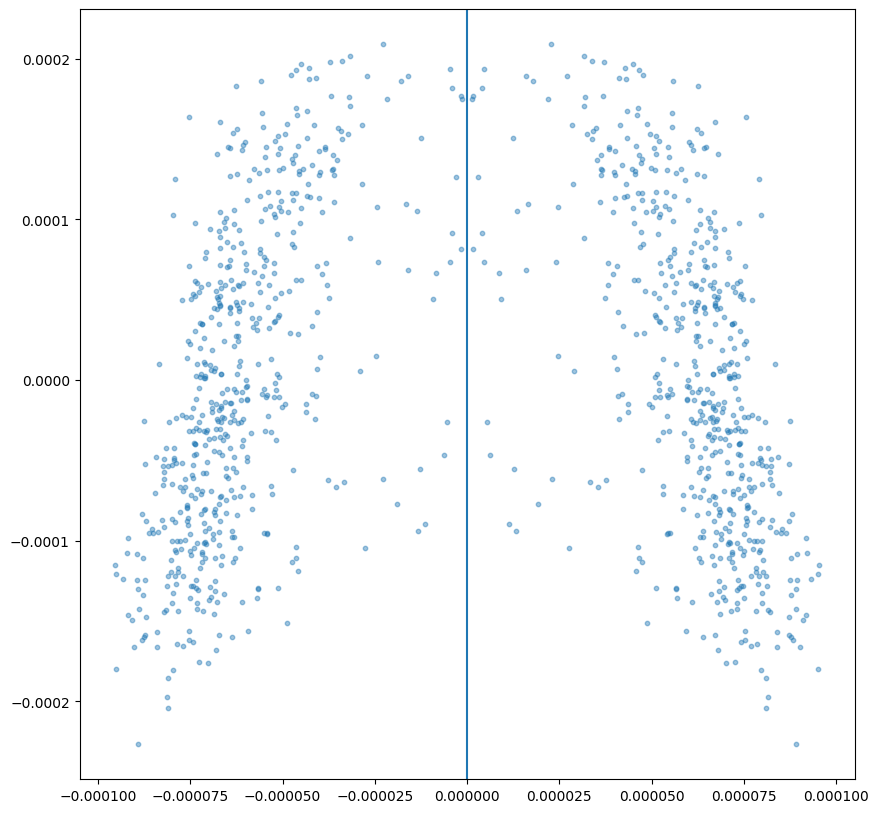

In [156]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(
        Z[:,0], 
        Z[:,1],
        marker="o",
        s=10,
        alpha=0.425,
        zorder=0,
    )
ax.axvline(x=0)

In [157]:
print(Z.shape)
Z_new = Z[Z[:,0] < 0]
images = images[Z[:,0] < 0]
print(Z_new.shape)

(1130, 2)
(565, 2)


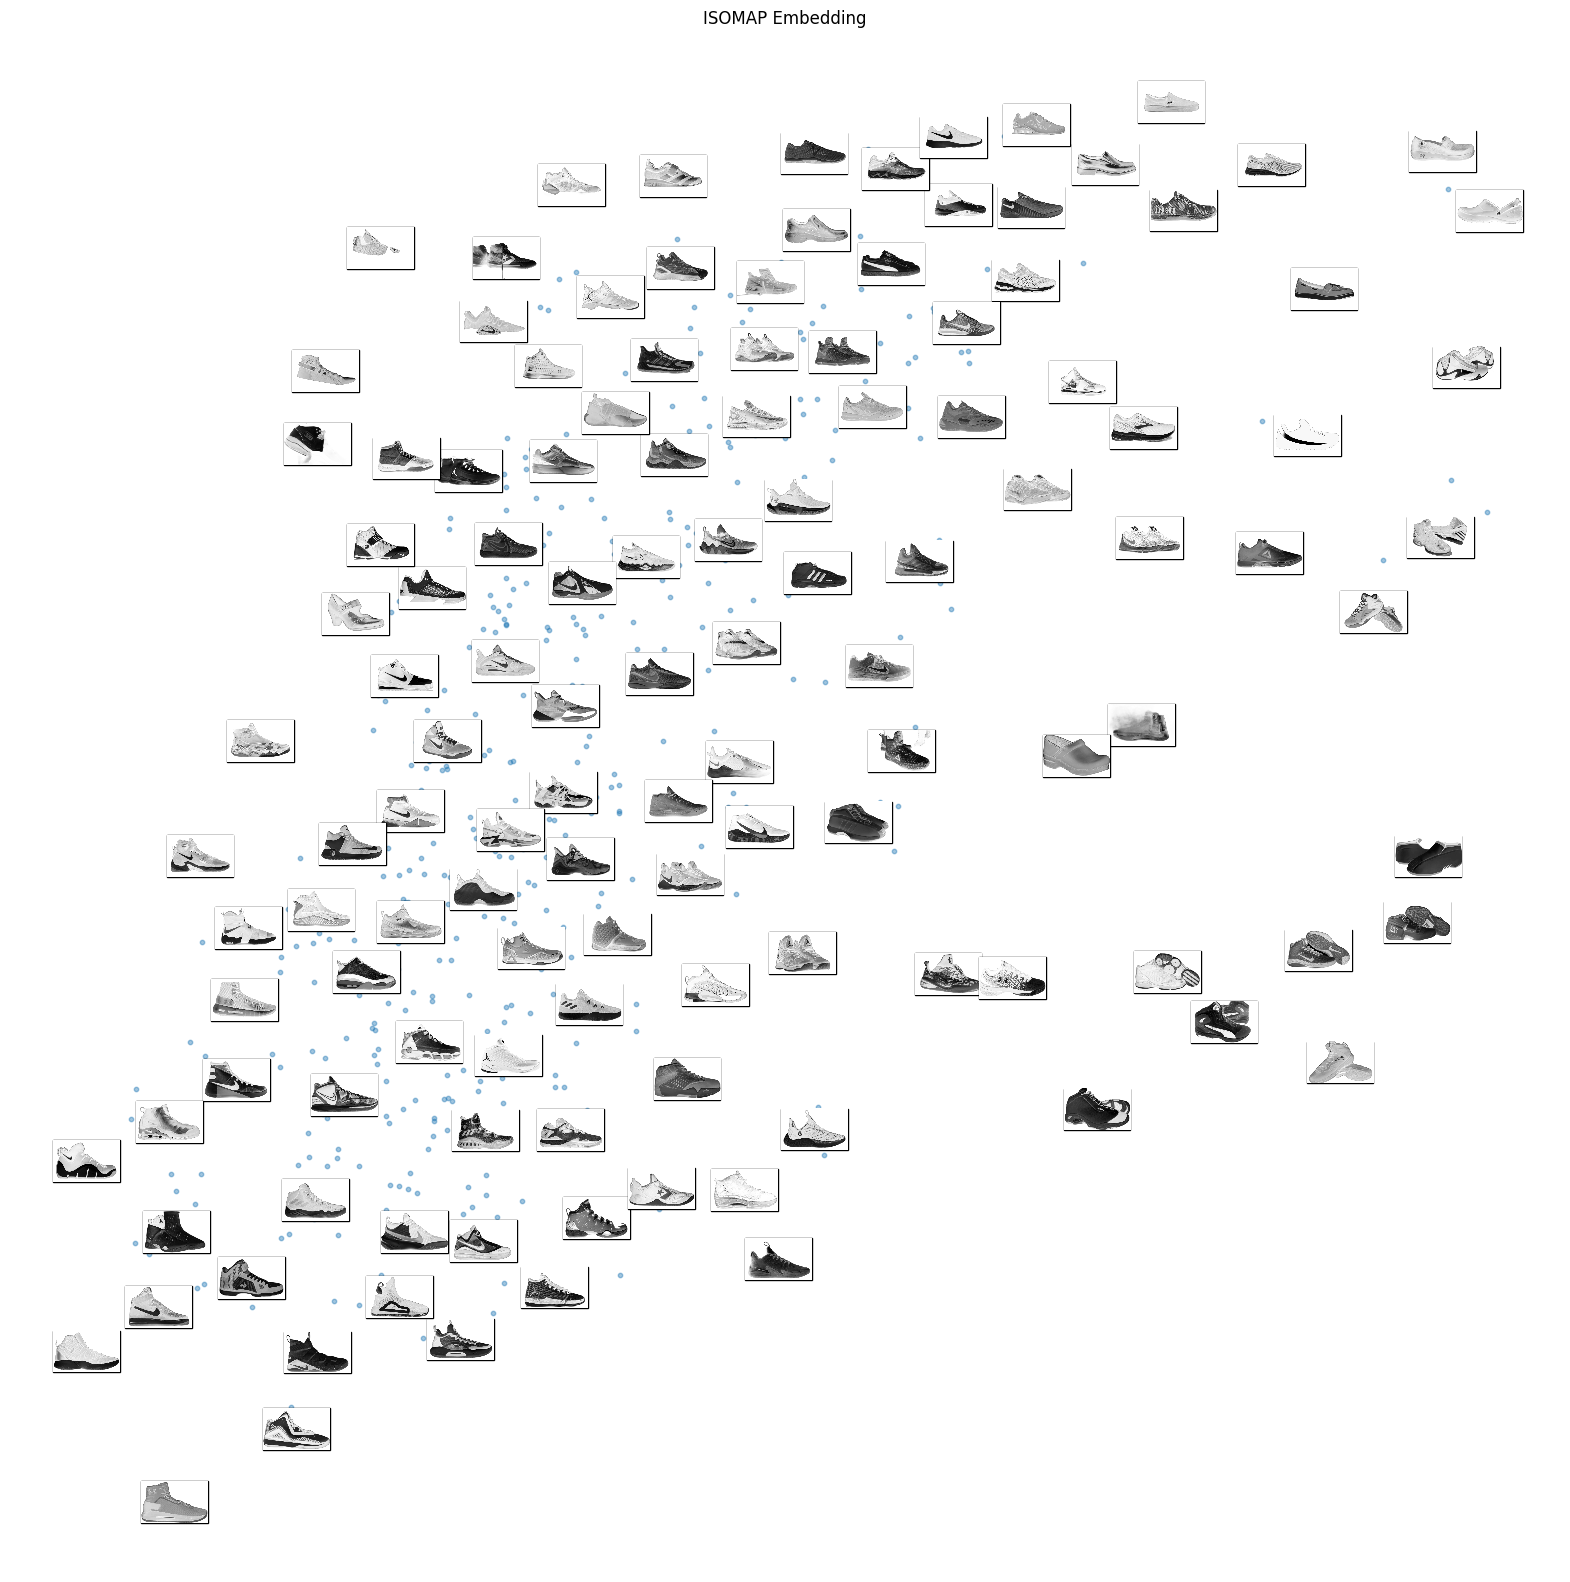

In [158]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

def plot_embedding(X, title):
    _, ax = plt.subplots(figsize=(20,20))
    X = MinMaxScaler().fit_transform(X)

    ax.scatter(
        X[:,0], 
        X[:,1],
        marker="o",
        s=10,
        alpha=0.425,
        zorder=0,
    )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(np.reshape(images[i], (250, 400)), zoom=0.12, cmap=plt.cm.gray_r), X[i], pad=0
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

plot_embedding(Z_new, "ISOMAP Embedding")

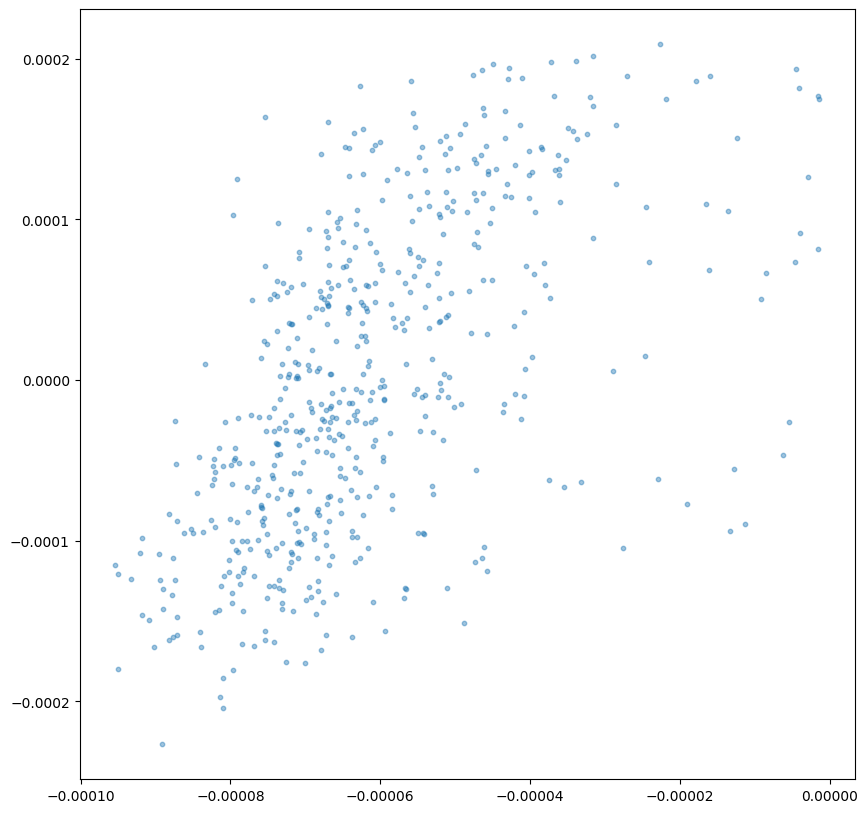

In [159]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(
        Z_new[:,0], 
        Z_new[:,1],
        marker="o",
        s=10,
        alpha=0.425,
        zorder=0,
    )

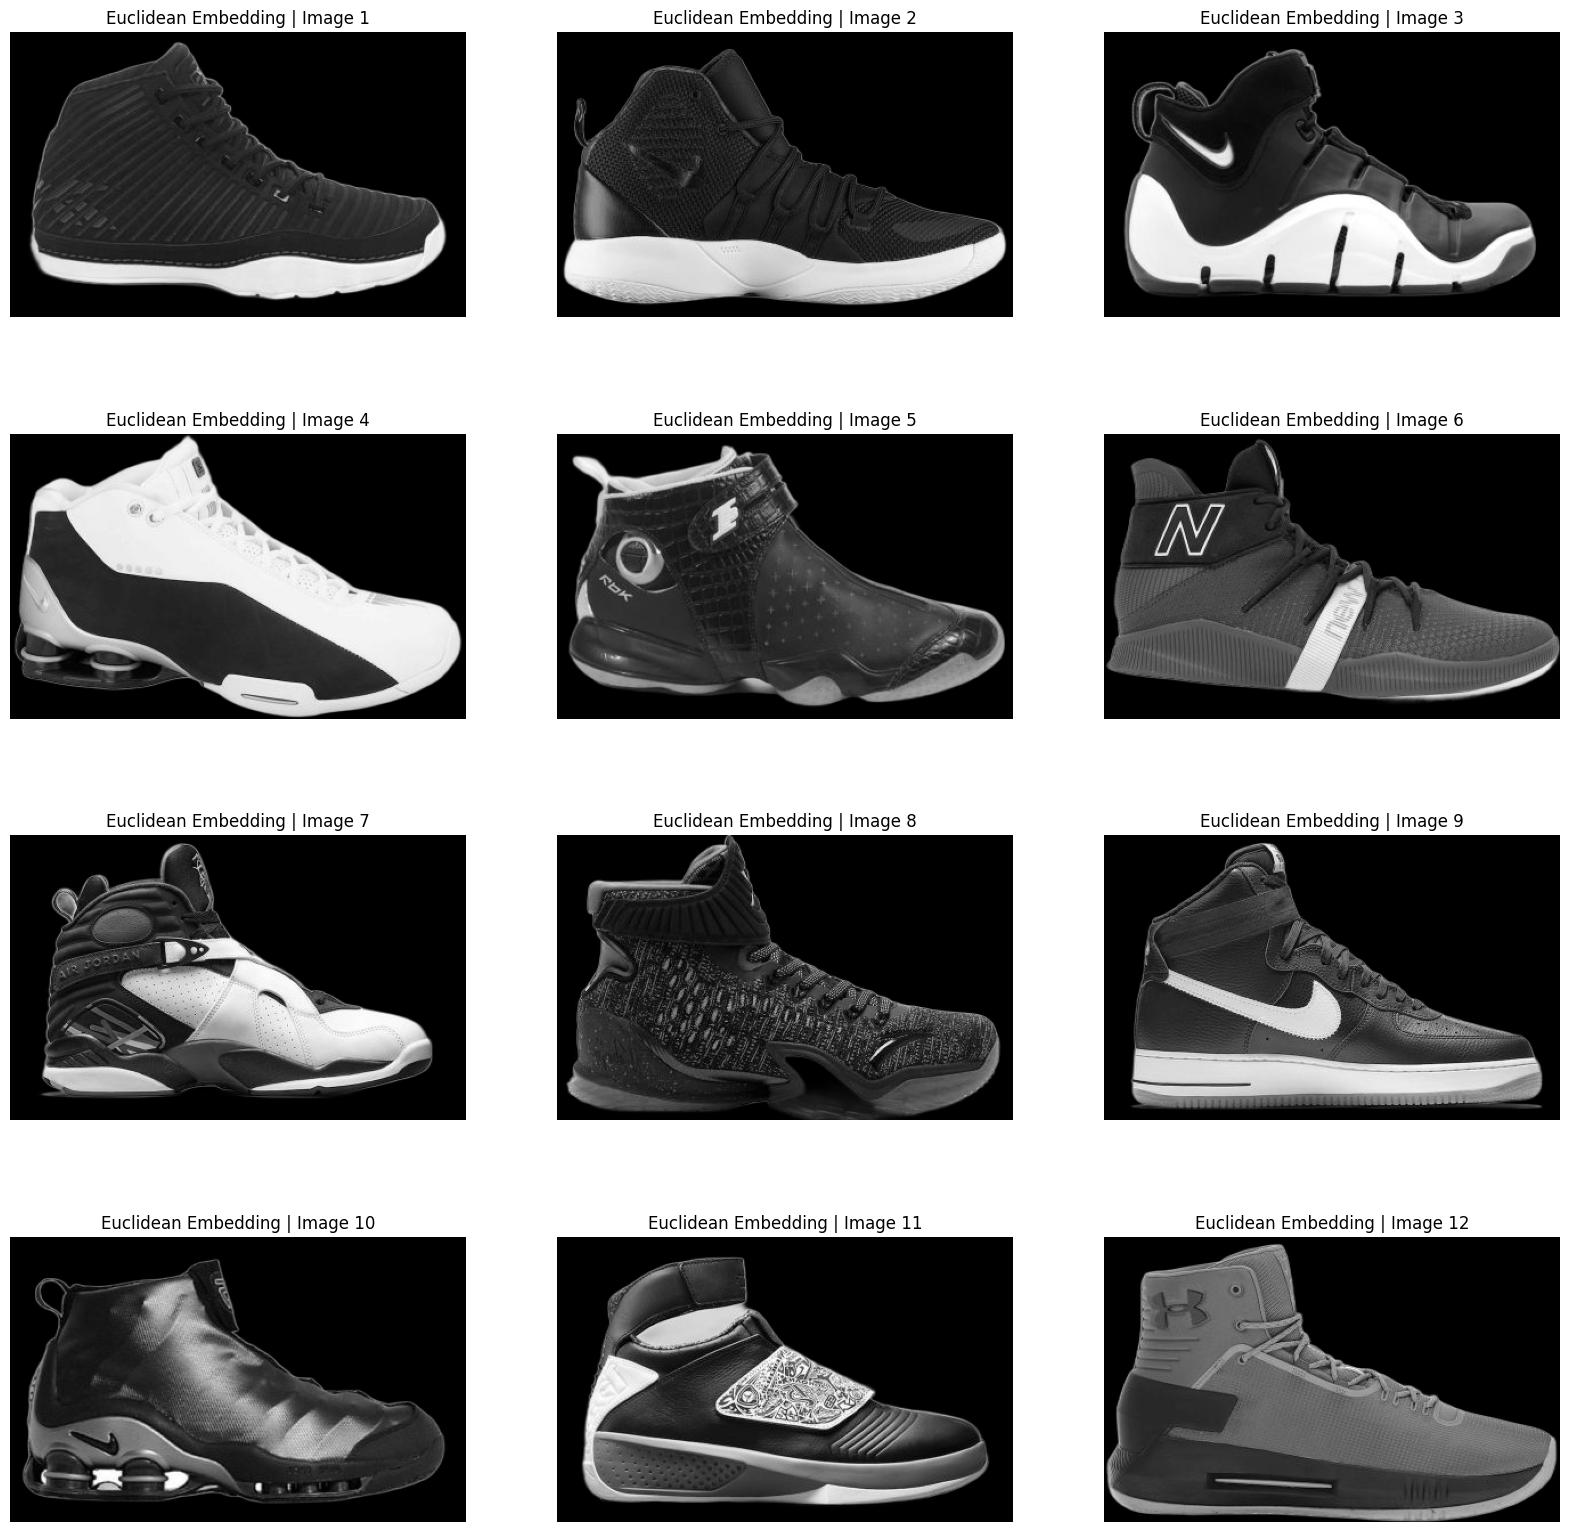

In [160]:
index = np.argsort(Z_new[:,0])[:12]
fig, axs = plt.subplots(4, 3, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.reshape(images[index[i]], (250,400)), cmap="gray")
    ax.set_title(f'Euclidean Embedding | Image {i+1}')
    ax.axis("off")